In [26]:
def DATparser(filename, labels):
    res = []

    with open(filename, 'r') as datfile:
        line = datfile.readline()
        delimiter = ','
        if line[4:8] == '2015': delimiter = '\t'
            
        while True:
            if not line:
                break
            if line[0:3] != '102':
                line = datfile.readline()
                continue
                
            line = line.split(delimiter)
            if 152 <= int(line[2]) <= 243:
                newline = [int(line[labels[0]]), int(line[labels[1]]), float(line[labels[2]]),
                           float(line[labels[3]]), 0, 0, float(line[labels[4]]), float(line[labels[5]])]
                newline[4] = 1 if newline[6] >= 0.1 else 0
                newline[5] = 1 if newline[7] >= 0.09 else 0
                res.append(newline)
                
            line = datfile.readline()

    return res

In [28]:
# key: [year, day, tmax, tmin, rain, dew]
labels = {1: (1, 2, 10, 12, 19, 28), 2: (1, 2, 12, 14, 21, 34)}


years = [2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

data = []

for year in years:
    filename = f"D:\\NIR\\Golit\\GOL{str(year)}.DAT"
    if year <= 2015:
        key = 1
    else:
        key = 2
    new = DATparser(filename, labels[key])
    new = [';'.join(str(j) for j in i) for i in new]
    data.append(new)
    print(filename)


with open("Golit//GOL1.csv", 'w') as goldat:
    for i in data:   # year
        for j in i:  # day
            goldat.writelines(j + "\n")


D:\NIR\Golit\GOL2005.DAT
D:\NIR\Golit\GOL2006.DAT
D:\NIR\Golit\GOL2007.DAT
D:\NIR\Golit\GOL2010.DAT
D:\NIR\Golit\GOL2011.DAT
D:\NIR\Golit\GOL2012.DAT
D:\NIR\Golit\GOL2013.DAT
D:\NIR\Golit\GOL2014.DAT
D:\NIR\Golit\GOL2015.DAT
D:\NIR\Golit\GOL2016.DAT
D:\NIR\Golit\GOL2017.DAT
D:\NIR\Golit\GOL2018.DAT
D:\NIR\Golit\GOL2019.DAT
D:\NIR\Golit\GOL2020.DAT
D:\NIR\Golit\GOL2021.DAT
D:\NIR\Golit\GOL2022.DAT


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys

import collections

import tensorflow as tf

from tensorflow.keras import layers

In [2]:
# handlers
def normalize(array):
    ma, mi = max(array), min(array)
    res = []
    for i in range(len(array)):
        res.append((array[i] - mi) / (ma - mi))
    return res


def days_classifier(day):
    sprouting, growth, maturation = [], [], []
    for i in range(len(day)):
        a, b, c = 0, 0, 0
        if day[i] < 185: a = 1
        elif day[i] >= 185 and day[i] <= 205:
            b = 1
        else:
            c = 1
        sprouting.append(a)
        growth.append(b)
        maturation.append(c)
    return sprouting, growth, maturation


# creating normalized DataFrame, days classified
def normDataFrame(source, boolean=0, dew=1, days=1):
    nTmax = normalize(source["Tmax"])
    nTmin = normalize(source["Tmin"])

    res = pd.DataFrame()
    res["Year"] = source["Year"]
    if days:
        sp, gr, mt = days_classifier(source["Day"])
        res["Sprouting"] = sp
        res["Growth"] = gr
        res["Maturation"] = mt
    res["Tmax"] = nTmax
    res["Tmin"] = nTmin
    
    if boolean:
        res["Rain"] = source["Rain"]
        if dew: res["Dew"] = source["Dew"]
    else:
        nRain = normalize(source["RainAmount"])
        res["Rain"] = nRain
        if dew: res["Dew"] = source["DewAmount"]
    
    return res

In [5]:
# reading raw data from csv
d = pd.read_csv("Golit/Gol_FULLDATA_fixed_new.csv", sep=";", names=["Year", "Day", "Tmax", "Tmin", "Rain", "Dew", "RainAmount", "DewAmount", 'kkk'])
yield_loss = pd.read_csv("Golit/GOL_loses.csv", sep=';', names=["Year", "Loses"])

# normalizing
data = normDataFrame(d, boolean=1)
yield_loss["Loses"] = yield_loss["Loses"] / 100

data_a = normDataFrame(d)

dd = pd.DataFrame(d[d["DewAmount"] != -1]).reset_index(drop=True)
data_rdn = normDataFrame(dd)
yield_loss_rdn = yield_loss[yield_loss['Year'] >= 2005]
yield_loss_d = pd.DataFrame(yield_loss_rdn[yield_loss_rdn["Year"] != 2007]).reset_index(drop=True)


# saving data from pandas
data.to_csv('D:\\NIR\\data\\data_boolean.csv', index=False)
data_a.to_csv('D:\\NIR\\data\\data_raw_normalized.csv', index=False)
yield_loss.to_csv('D:\\NIR\\data\\loses.csv', index=False)

data_rdn.to_csv('D:\\NIR\\data\\data_includingDew_normalized.csv', index=False)
yield_loss_d.to_csv('D:\\NIR\\data\\loses_includingDew.csv', index=False)

In [6]:
d

,Year,Day,Tmax,Tmin,Rain,Dew,RainAmount,DewAmount,kkk
0,1972,153,20.30,9.50,1,-1,0.800,-1.000,NaN
1,1972,154,20.50,7.80,0,-1,0.100,-1.000,NaN
2,1972,155,18.40,15.10,1,-1,0.400,-1.000,NaN
3,1972,156,19.10,9.10,1,-1,0.500,-1.000,NaN
4,1972,157,18.70,5.70,0,-1,0.000,-1.000,NaN
...,...,...,...,...,...,...,...,...,...
2976,2022,239,32.70,12.51,0,0,0.000,0.057,NaN
2977,2022,240,32.10,14.38,0,0,0.000,0.001,NaN
2978,2022,241,26.40,14.24,0,1,0.000,0.107,NaN
2979,2022,242,30.65,16.40,0,1,0.000,0.172,NaN


In [3]:
# MICHURINSK
m = pd.read_csv('D:\\NIR\\data\\michurinsk_from_excel.csv', sep=';',
                            names=['Year', 'Day', 'Tmax', 'Tmin', 'RainAmount'])
m = m[m['Day'] >= 152].reset_index(drop=True)
m = m.drop(labels=['Day'], axis=1)
michurinsk_22 = normDataFrame(m, dew=0, days=0)
michurinsk_22.to_csv('D:\\NIR\\data\\michutinsk_2022_normalized.csv', index=False)

In [258]:
mb = pd.read_csv('D:\\NIR\\data\\michurinsk_bool_from_excel.csv', sep=';',
                 names=['Year', 'Day', 'Tmax', 'Tmin', 'Rain'])
mb = mb[mb['Day'] >= 152].reset_index(drop=True)
mb = mb.drop(labels=['Day'], axis=1)
mb_22 = normDataFrame(mb, dew=0, days=0, boolean=1)
mb_22.to_csv('D:\\NIR\\data\\michurinsk_2022_boolrain.csv', index=False)

In [5]:
# reading preprocessed data from file
data_all = pd.read_csv('D:\\NIR\\data\\data_booleanRain_normalized.csv', )
                   #names=['Year', 'Sprouting', 'Growth', 'Maturation', 'Tmax', 'Tmin', 'Rain', 'Dew'])
yield_loss = pd.read_csv('D:\\NIR\\data\\loses.csv',)
                        #names=['Year', 'Loses'])
data_na = pd.read_csv('D:\\NIR\\data\\data_includingDew_normalized.csv')

yield_loss_na = pd.read_csv('D:\\NIR\\data\\loses_includingDew.csv')

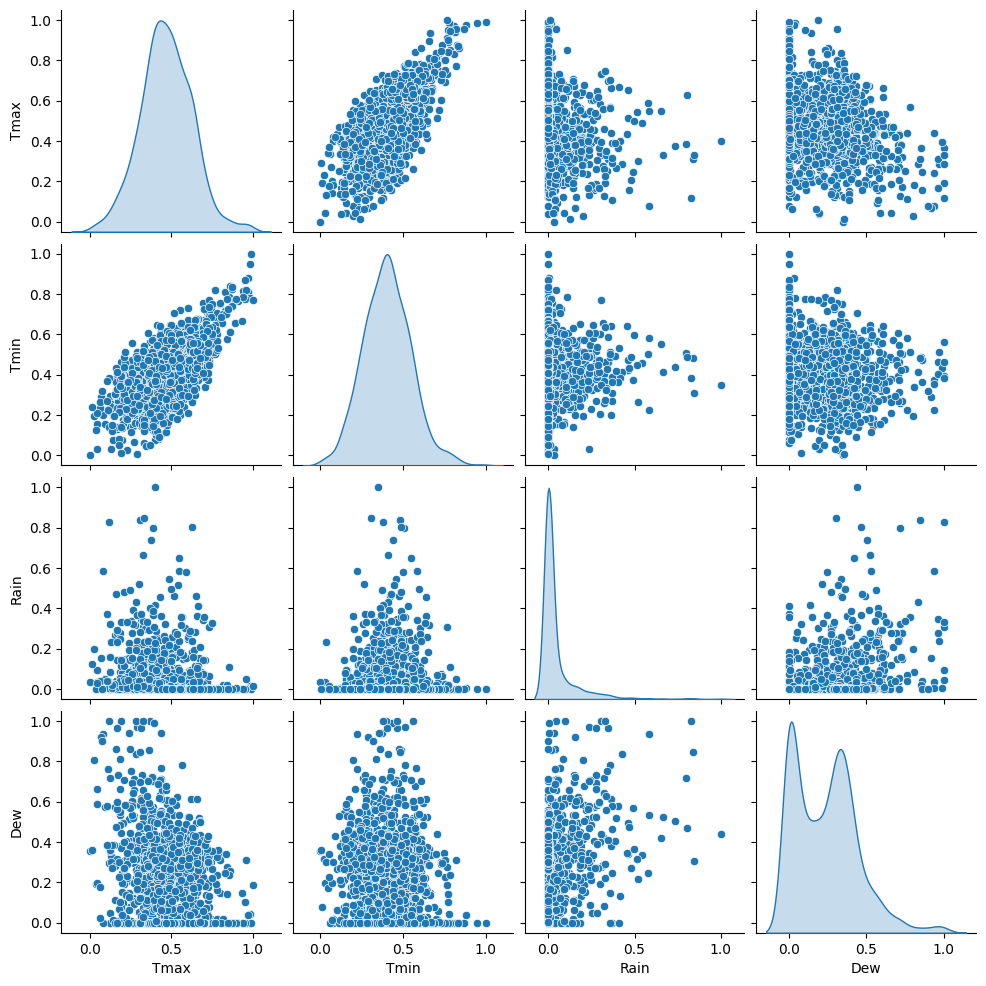

In [55]:
#ispecting raw data (only years where dew data given)
sns.pairplot(data_na[["Tmax", "Tmin", "Rain", "Dew"]], diag_kind='kde')

In [64]:
#take a look on Tmin, Tmax, RainAmount
data_all.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,2981.0,2001.160349,14.531975,1972.0,1992.00,2004.0,2014.000,2022.0
Day,2981.0,197.194901,26.548359,152.0,174.00,197.0,220.000,244.0
Tmax,2981.0,23.519111,5.150962,7.0,20.10,23.5,26.800,42.7
Tmin,2981.0,11.783404,3.682324,0.3,9.31,11.9,14.300,27.8
Rain,2981.0,0.273734,0.445949,0.0,0.00,0.0,1.000,1.0
Dew,2981.0,-0.252935,0.891286,-1.0,-1.00,-1.0,1.000,1.0
RainAmount,2981.0,1.904805,4.563980,0.0,0.00,0.0,1.400,43.5
DewAmount,2981.0,-0.448968,0.631007,-1.0,-1.00,-1.0,0.187,1.0


In [65]:
#take a look on DewAmount
data_na.describe().transpose()[6:]

,count,mean,std,min,25%,50%,75%,max
Rain,1325.0,0.046798,0.109994,0.0,0.000,0.000,0.035354,1.0
Dew,1325.0,0.239718,0.204360,0.0,0.044,0.242,0.365000,1.0


In [11]:
def fixed_length_random_sequence(a, b, l, y):
    if y == 2010 and b > 85: b = 85
    if y == 2011 and b > 83: b = 83
    if y == 2015 and b > 48: b = 48
    while True:
        res =  np.sort(np.random.default_rng().integers(low=a, high=b, size=l))
        if len(set(res)) == l:
            return res

def fixed_length_homogenous_sequence(a, b, l, y):
    if y == 2010 and b > 85: b = 85
    if y == 2011 and b > 83: b = 84
    if y == 2015 and b > 48: b = 48
    
    step = int((b - a) / l)
    res = [j for j in range(a, b+1, step)]
    return res
        
# extracts data series and creates set of training vectors and set of labels, days aren't classified
def serial_extractor(years, source, begin, end, fdew=0, frain=0, loses=1):
    X = []
    if loses:
        Y = []
    for current_year in years:
        tmp = source[source["Year"] == current_year].copy(deep=True).reset_index(drop=True)
        tmax = tmp["Tmax"][begin:end]
        tmin = tmp["Tmin"][begin:end]
        if frain:
            rain = tmp["Rain"][begin:end]
        if fdew:
            dew = tmp["Dew"][begin:end]
    
        try:
            if loses:
                Y.append(float(yield_loss[yield_loss["Year"] == current_year]["Loses"]))
                
            base = [*tmax, *tmin]
            
            if frain: base = [*base, *rain]
            if fdew: base = [*base, *dew]
            
            base = np.array(base)
            X.append(base)
            
        except:
            print(f"There's an error with year: {current_year}")
            
    return (X, Y) if loses else X


# extracts fixed length sequence of days with homogenous/random distirbution (random by default)
def point_extractor(years, source, begin, end, number, fdew=0, frain=0, loses=1, periods=0, homogenous=0):
    X = []
    if loses:
        Y = []
    for current_year in years:
        tmp = source[source["Year"] == current_year].copy(deep=True).reset_index(drop=True)
        tmax, tmin = [], []
        if frain:
            rain = []
        if fdew:
            dew = []
        if periods:
            sp, gr, mt = [], [], []
        
        if homogenous:
            index = fixed_length_homogenous_sequence(begin, end, number, current_year)
        else:
            index = fixed_length_random_sequence(begin, end, number, current_year) 
        
        for i in index:
            tmax.append(tmp["Tmax"][i])
            tmin.append(tmp["Tmin"][i])
            if frain:
                rain.append(tmp["Rain"][i])
            if fdew:
                dew.append(tmp["Dew"][i])
            if periods:
                sp.append(tmp["Sprouting"][i])
                gr.append(tmp["Growth"][i])
                mt.append(tmp["Maturation"][i])
        
        try:
            if loses:
                Y.append(float(yield_loss[yield_loss["Year"] == current_year]["Loses"]))
            
            base = [*tmax, *tmin]
            
            if frain: base = [*base, *rain]
            if fdew: base = [*base, *dew]
            if periods: base = [*sp, *gr, *mt, *base]
                
            base = np.array(base)
            X.append(base)

        except:
            print(f"There's an error with year: {current_year}")
            
    return (X, Y) if loses else X


In [282]:
# separate train and validation sets
def trainval(X, Y):
    
    if len(X) < 4:
        print('X is too short for slicing: ', len(X))
        return X, Y, [], []
    
    X_train = X[2:-3]
    Y_train = Y[2:-3]

    X_val = [ X[0], X[1], X[-2], X[-1] ]
    Y_val = [ Y[0], Y[1], Y[-2], Y[-1] ]

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    if len(X) < 8:
        print('X is shorter than 8')
        X_train, X_val = X_val, X_train
        Y_train, Y_val = Y_val, Y_train
    
    return X_train, Y_train, X_val, Y_val


# training set replication by mult_factor
def replicate(X, Y, mult_factor=7, mutable=0):
    
    vector_size = len(X[0])
    X_ext, Y_ext = [], []
    
    for i in range(len(X)):
        for j in range(mult_factor):
            X_ext.append(X[i] + np.array(list(np.random.normal(0, 0.002, vector_size - mutable)) + [0]*mutable))
            Y_ext.append([Y[i]])
            
    X_ext = np.array(X_ext)
    Y_ext = np.array(Y_ext)
    
    return X_ext, Y_ext

In [207]:
# forming training and validation sets
def sets_prepare(bool_source, source, yearset, dew_yearset, prognoze_yearset=0, data_type='series', begin=0, end=54, number=14, prognoze=1):
    if data_type == "series":
        get = serial_extractor
        arg = (begin, end)
    elif data_type == "distributed":
        get = point_extractor
        arg = (begin, end, number)
        
    # only temperature    
    X_nt_t, Y_nt_t, X_nt_v, Y_nt_v = trainval(*get(yearset, bool_source, *arg))
    # temperature and rain
    X_nr_t, Y_nr_t, X_nr_v, Y_nr_v = trainval(*get(yearset, source, *arg, frain=1))
    # temperature, boolean rain
    X_ba_t, Y_ba_t, X_ba_v, Y_ba_v = trainval(*get(yearset, bool_source, *arg, frain=1))
    # temperature, rain and dew
    X_na_t, Y_na_t, X_na_v, Y_na_v = trainval(*get(dew_yearset, source, *arg, frain=1, fdew=1))

    X_t_ext, Y_t_ext = [], []
    
    for i,j,k in ((X_nt_t, Y_nt_t, 0), (X_nr_t, Y_nr_t, number), (X_ba_t, Y_ba_t, number*2), (X_na_t, Y_na_t, number)):
        X_tmp, Y_tmp = replicate(i, j, 2, k)
        X_t_ext.append(X_tmp)
        Y_t_ext.append(Y_tmp)
    
    X_v = [X_nt_v, X_nr_v, X_ba_v, X_na_v]
    Y_v = [Y_nt_v, Y_nr_v, Y_ba_v, Y_na_v]
    
    for i in range(len(X_t_ext)):
        X_t_ext[i] = tf.expand_dims(X_t_ext[i], 1)
    for i in range(len(X_v)):
        X_v[i] = tf.expand_dims(X_v[i], 1)

    if prognoze:
        P_nt = get(prognoze_yearset, bool_source, *arg, loses=0)
        P_nr = get(prognoze_yearset, source, *arg, frain=1, loses=0)
        P_ba = get(prognoze_yearset, bool_source, *arg, frain=1, loses=0) # fdew=1
        P_na = get(prognoze_yearset, source, *arg, frain=1, fdew=1, loses=0)
        
        P = [P_nt, P_nr, P_ba, P_na]
            
        for i in range(len(P)):
            P[i] = tf.expand_dims(P[i], 1)

        return X_t_ext, Y_t_ext, X_v, Y_v, P
    
    return X_t_ext, Y_t_ext, X_v, Y_v

In [66]:
def transform_for_RNN(source, types_count):
    length = len(source[0][0])
    days = length / types_count
    if days % 1 != 0:
        print(f'Sample length does not match number of data types: {length} / {types_count} = {days}')
    days = int(days)
    
    result = []
    for i in range(len(source)):
        tmp = np.matrix(source[i][0])
        tmp = tmp.reshape(types_count, days)
        tmp = tmp.transpose()
        result.append([tmp])
    
    return result

def RNN_format(train, val, prog, k):
    T, V, P = [], [], []
    for source,res in ((train, T), (val,V), (prog,P)):
        for i in range(len(source)):
            res.append(transform_for_RNN(source[i], k[i]))
        
    return T, V, P

In [701]:
boolean = pd.read_csv('D:\\NIR\\data\\data_boolean.csv')
data_rn = pd.read_csv('D:\\NIR\\data\\data_raw_normalized.csv')

yield_loss = pd.read_csv('D:\\NIR\\data\\loses.csv',)

yearset = set(list(data_rn[data_rn["Year"] < 2018]["Year"]))
prognoze_yearset = (2018, 2019, 2020, 2021, 2022)
dew_yearset = set(list(data_rn[data_rn["Dew"] != -1]["Year"]))
for i in prognoze_yearset:
    dew_yearset.remove(i)
dew_yearset_fix = dew_yearset.copy()
dew_yearset_fix.remove(2015)
yearset_fix = yearset.copy()
yearset_fix.remove(2015)
yearset_fix.remove(1994)

# beginning of summer
#Xb_train, Yb_train, Xb_val, Yb_val, Pb = sets_prepare(boolean, data_rn,
#                                                        yearset, dew_yearset, prognoze_yearset,
#                                                        data_type='series',
#                                                        begin=0, end=21)

# dangerous period
Xd_train, Yd_train, Xd_val, Yd_val, Pd = sets_prepare(boolean, data_rn,
                                                        yearset_fix, dew_yearset_fix, prognoze_yearset,
                                                        data_type='series',
                                                        begin=34, end=55)


# distributed points
#Xp_train, Yp_train, Xp_val, Yp_val, Pp = sets_prepare(boolean, data_rn,
#                                                        yearset, dew_yearset, prognoze_yearset,
#                                                        data_type='distributed',
#                                                        begin=0, end=92,
#                                                        number=14)


In [168]:
#making RNN sets
rXb_train, rXb_val, rPb = RNN_format(Xb_train, Xb_val, Pb, (2,3,3,4))
rXd_train, rXd_val, rPd = RNN_format(Xd_train, Xd_val, Pb, (2,3,3,4))

In [106]:
######## ЗАСУНУТЬ EXPAND_DIMS В ГЕНЕРАТОР ########## ФУНКЦИОНАЛ ПЕРЕНЕСТИ В SETS_PREPARE
def make_prognoze_set(source, yearset, begin, end, dew=0, dew_source=0, dew_yearset=0, fbool=0, bool_source=0, bool_yearset=0):
    P_nt = serial_extractor(yearset, source, begin, end, loses=0)
    P_nt = tf.expand_dims(P_nt,1)
    P_nr = serial_extractor(yearset, source, begin, end, loses=0, frain=1)
    P_nr = tf.expand_dims(P_nr,1)
    if dew:
        P_na = serial_extractor(dew_yearset, dew_source, begin, end, loses=0, frain=1, fdew=1)
        P_na = tf.expand_dims(P_na,1)
        if fbool:    
            P_ba = serial_extractor(dew_yearset, bool_source, begin, end, loses=0, frain=1, fdew=1)
            P_ba = tf.expand_dims(P_ba,1)
            return [P_nt, P_nr, P_ba, P_na]
        
        return [P_nt, P_nr, P_na]
    
    return [P_nt, P_nr]


In [315]:
michurinsk = pd.read_csv('D:\\NIR\\data\\michutinsk_2022_normalized.csv')
Md = serial_extractor(source=michurinsk, years=[2022], loses=0, begin=34, end=55, frain=1)
Md = tf.expand_dims(Md, 1)

michurinsk_bool = pd.read_csv('D:\\NIR\\data\\michurinsk_2022_boolrain.csv')
Mdb = serial_extractor(source=michurinsk_bool, years=[2022], loses=0, begin=34, end=55, frain=1)
Mdb = tf.expand_dims(Mdb, 1)

In [29]:
import tensorflow_transform as tft
# implementing PCA to every year to examine maximum dispersion directions
yearset = set(list(d["Year"]))
# we don't need boolean columns for pca
d.drop(["Rain", "Dew"], axis=1)
tf.compat.v1.disable_eager_execution()
vec = []
for year in yearset:
    vec.append(tft.pca(tf.convert_to_tensor(d[d["Year"] == year]), output_dim=2, dtype=tf.float32))

pca_res = pd.DataFrame(list(zip(yearset, vec)), columns=["Year", "PCA"])

<tf.Operation 'PrintV2' type=PrintV2>

In [39]:
# how to print tensor with TFv2???
tf.print(vec[0], output_stream=sys.stdout)

<tf.Operation 'PrintV2_2' type=PrintV2>

In [778]:
model_d = tf.keras.Sequential([
                              layers.Dense(21, activation='relu'),
                              layers.Dense(12, activation='relu'),
                              layers.Dense(4, activation='relu'),
                              layers.Dense(1, activation='softsign')
])


model_d.compile(optimizer='adam',
               loss=('mae'))

In [779]:
checkpoint_path = "D:\\NIR\\training_1\\cp_ext1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


loses = model_d.fit(Xd_train[1], Yd_train[1],
                 validation_data = (Xd_val[1], Yd_val[1]),
                 batch_size=15,
                 epochs=70,
                 )

Epoch 1/70
3/3 [==============================] - 1s 76ms/step - loss: 0.2128 - val_loss: 0.1093
Epoch 2/70
3/3 [==============================] - 0s 12ms/step - loss: 0.2020 - val_loss: 0.1356
Epoch 3/70
3/3 [==============================] - 0s 13ms/step - loss: 0.1906 - val_loss: 0.1629
Epoch 4/70
3/3 [==============================] - 0s 13ms/step - loss: 0.1812 - val_loss: 0.1822
Epoch 5/70
3/3 [==============================] - 0s 13ms/step - loss: 0.1765 - val_loss: 0.1935
Epoch 6/70
3/3 [==============================] - 0s 12ms/step - loss: 0.1759 - val_loss: 0.2021
Epoch 7/70
3/3 [==============================] - 0s 13ms/step - loss: 0.1745 - val_loss: 0.2037
Epoch 8/70
3/3 [==============================] - 0s 13ms/step - loss: 0.1719 - val_loss: 0.1980
Epoch 9/70
3/3 [==============================] - 0s 12ms/step - loss: 0.1698 - val_loss: 0.1917
Epoch 10/70
3/3 [==============================] - 0s 11ms/step - loss: 0.1684 - val_loss: 0.1812
Epoch 11/70
3/3 [============

<Axes: >

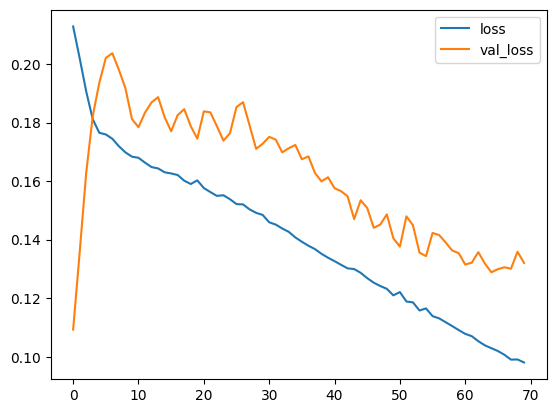

In [780]:
loss_df = pd.DataFrame(loses.history)
loss_df.loc[:,['loss', 'val_loss']].plot()

In [781]:
model_d.predict(Pd[1])

1/1 [==============================] - 0s 99ms/step


array([[[0.37459368]],

       [[0.18938652]],

       [[0.17450154]],

       [[0.29801747]],

       [[0.19347061]]], dtype=float32)

In [782]:
model_d.predict(Md)

1/1 [==============================] - 0s 16ms/step


array([[[0.5545551]]], dtype=float32)

In [691]:
model_d.save('D:\\NIR\\model\\model_d_2002_rn', save_format='h5')

In [127]:
import keras

In [393]:
boolean = pd.read_csv('D:\\NIR\\data\\data_boolean.csv')
data_rn = pd.read_csv('D:\\NIR\\data\\data_raw_normalized.csv')

yield_loss = pd.read_csv('D:\\NIR\\data\\loses.csv')

four_groups_yearset = damage_sort(yield_loss, 0.25)
ten_groups_yearset = damage_sort(yield_loss, 0.1)

Xd_4_train, Yd_4_train, Xd_4_val, Yd_4_val, Pd_4 = [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]

for i in range(3): 
    Xd_4_train[i], Yd_4_train[i], Xd_4_val[i], Yd_4_val[i] = sets_prepare(boolean, data_rn,
                                                                          four_groups_yearset[i], four_groups_yearset[i],
                                                                          data_type='series', begin=34, end=55,
                                                                          prognoze=0)

Xd_10_train, Yd_10_train, Xd_10_val, Yd_10_val, Pd_10 = [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], \
                                                        [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]

for i in range(6):
    print(i)
    Xd_10_train[i], Yd_10_train[i], Xd_10_val[i], Yd_10_val[i] = sets_prepare(boolean, data_rn,
                                                                              ten_groups_yearset[i], ten_groups_yearset[i],
                                                                              data_type='series', begin=34, end=55,
                                                                              prognoze=0)

X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
0
1
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
2
X is shorter than 8
X is shorter than 8
X is shorter than 8
X is shorter than 8
3
X is too short for slicing:  2
X is too short for slicing:  2
X is too short for slicing:  2
X is too short for slicing:  2


ValueError: operands could not be broadcast together with shapes (42,) (0,) 

In [376]:
def damage_sort(s, step):
    p = []
    for i in np.arange(0,1+step,step):
        tmp = s[s['Loses'] <= i+step]
        tmp = tmp[tmp['Loses'] >= i].reset_index(drop=True)
        tmp = set(tmp['Year'])
        if 2009 in tmp: tmp.remove(2009)
        if 2015 in tmp: tmp.remove(2015)
        if 2010 in tmp: tmp.remove(2010)
        if 2007 in tmp: tmp.remove(2007)
        p.append(tmp)
    
    return p

In [790]:
rec_model_d = tf.keras.Sequential([
                              layers.SimpleRNN(21, activation='relu'),
                              layers.Dense(12, activation='relu'),
                              layers.Dense(6, activation='relu'),
                              layers.Dense(1, activation='softsign'),
])


rec_model_d.compile(optimizer='adam',
                  loss=('mae'))

In [795]:
loses = rec_model_d.fit(Xd_train[1], Yd_train[1],
                      validation_data = (Xd_val[1], Yd_val[1]),
                      batch_size=15,
                      epochs=5,
                     )

Epoch 1/5
3/3 [==============================] - 0s 25ms/step - loss: 0.0817 - val_loss: 0.0992
Epoch 2/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0786 - val_loss: 0.1054
Epoch 3/5
3/3 [==============================] - 0s 13ms/step - loss: 0.0772 - val_loss: 0.1078
Epoch 4/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0782 - val_loss: 0.1042
Epoch 5/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0758 - val_loss: 0.1005


<Axes: >

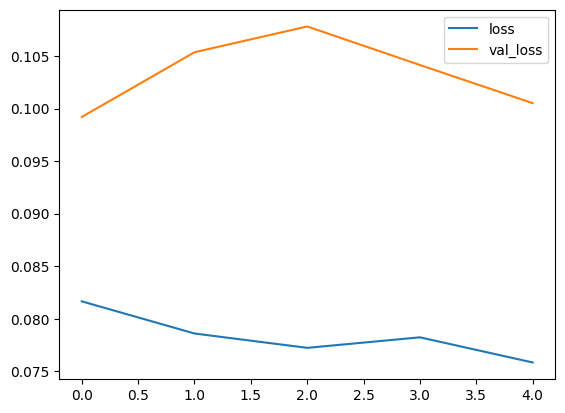

In [796]:
loss_df = pd.DataFrame(loses.history)
loss_df.loc[:,['loss', 'val_loss']].plot()

In [797]:
rec_model_d.predict(Pd[1])

1/1 [==============================] - 0s 109ms/step


array([[0.25938186],
       [0.17721623],
       [0.20279315],
       [0.1497041 ],
       [0.150901  ]], dtype=float32)

In [798]:
rec_model_d.predict(Md)

1/1 [==============================] - 0s 16ms/step


array([[0.5981805]], dtype=float32)

In [799]:
rec_model_d.save('D:\\NIR\\model\\rec_model_d_1994', save_format='h5')